## Look at the OA breakdown of individual publishers
- Simple visualisation to see what % of each publishers' content is gold, green, etc. 


In [1]:
%matplotlib inline
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tools.PublisherNameConsolidator import PublisherNameConsolidator
publisher_name_consolidator = PublisherNameConsolidator().publisher_name_consolidator
publisher_dct = PublisherNameConsolidator().publisher_dct

In [3]:
# Which date range are we interested in?
# Set these variables to months in the format 'YYYY-MM'
start_month = '2010-01'
end_month = '2020-12'
assert end_month>=start_month

In [4]:
from tools.PublisherCountsByType import PublisherCountsByType
allowed_months = PublisherCountsByType().build_allowed_months(start_month, end_month)
allowed_months_set = set(allowed_months)

In [5]:
from tools.UnpaywallDataFrame import UnpaywallDataFrame
from config import Config
dataframe_path = os.path.join(Config['data_path'],'unpaywall_dataframe.csv')
df = UnpaywallDataFrame(
    snapshot_path = filepath,
    dataframe_path = dataframe_path,
    allowed_months = allowed_months
).build_load_dataframe()
df.shape

TypeError: 'type' object is not subscriptable

In [6]:
df.head()

,count,subscription_count,hybrid_count,gold_count,bronze_count,green_count,bronze_green_count,gold_green_count,hybrid_green_count,publisher,month
0,6,0,0,6,0,0,0,3,0,Centennial Library,2010-01
1,1366,8,1358,0,0,0,0,0,0,"Acta Physica Sinica, Chinese Physical Society ...",2010-01
2,17,0,0,0,17,0,3,0,0,The Japanese Society for Oral Pathology,2010-01
3,12,0,12,0,0,0,0,0,0,Elementary Education Research Institute,2010-01
4,26,0,0,0,26,0,5,0,0,Western Australian Museum,2010-01


In [7]:
# what columns of data are available?
df.columns

Index(['count', 'subscription_count', 'hybrid_count', 'gold_count',
       'bronze_count', 'green_count', 'bronze_green_count', 'gold_green_count',
       'hybrid_green_count', 'publisher', 'month'],
      dtype='object')

# Visualisations
Let's take a look at the data for different publishers and see if we can build a picture of the different kinds of OA that they publish.

see: https://python-graph-gallery.com/251-stacked-area-chart-with-seaborn-style/

## Define a visualisation function

Due to the issues around dates, and general noise in the data, I've chosen to use a rolling-12-month average. That seems to work ok for showing the overall trends, but there are still a lot of large, seemingly random fluctuations in the totals.

It's worth noting that there are some other issues here:
- Wiley had a huge spike in their data right after the merger with Blackwell ~2010. That is still visible here. 
- Oddly, some MDPI seems to be listed as hybrid/bronze etc. That is presumably an error?


In [11]:
def publisher_plot(df,publisher,percent=True):

    # first separate data pertaining to the publisher from the dataframe
    df_plot = df[df['publisher']==publisher]
    # rename the columns so that the labels look bit nicer in our plot
    df_plot = df_plot.rename(columns = {'subscription_count':'Subscription',
                              'bronze_count':'Bronze',
                              'green_count':'Green',
                              'hybrid_count':'Hybrid',
                             'gold_count':'Gold',
                             })
    # limit to the columns we're interested in
    df_plot = df_plot[['month','Subscription','Bronze','Green','Hybrid','Gold']]
    # separate the x-axis data and convert to a date-type object
    x = pd.to_datetime(df_plot.pop('month'), format='%Y-%m') #infer_datetime_format=True)
    # pick a window to average over. Set to 12 gives us a 12-month rolling average
    win_size = 12
    df_plot = df_plot.rolling(win_size,win_type=None).sum().tail(-1*(win_size-1))#.reset_index()
    
    if percent==True:
        df_plot = 100*df_plot.divide(df_plot.sum(axis=1),axis=0)
    else:
        pass

    # define chart and set size
    fig,ax = plt.subplots(figsize=(16,12))

    plt.stackplot(x[win_size-1:],  
                  df_plot['Subscription'],df_plot['Bronze'],df_plot['Green'],df_plot['Hybrid'],df_plot['Gold'],
                  labels=list(df_plot.columns),
                 colors = ['blue','orange','green','purple','gold',])
    
    
    y_label = 'Percent' if percent==True else 'Count'
    plt.title('{} - {} of Open access by type\nRolling 12-month average, Dataset: Unpaywall'.format(y_label, publisher), size = 20)
    
    # optional formatting changes
    plt.legend(loc='lower left')
    plt.margins(0,0)
    # ax.set_xticklabels(labels = x[win_size-1:], rotation=90, size = 8)
    # ax.set_yticklabels(labels = [x/10 for x in range(10)], size = 12)
    
    ax.set_xlabel('Month')
    
    ax.set_ylabel(y_label)
    # define a filename and write-out
    fig_filename = '{} of OA types {} - rolling average.png'.format(y_label, publisher)
    fig_path = os.path.join(Config.images_dir, fig_filename)
    plt.savefig(fig_path)
    plt.show()

2021-03-23 11:52:42,571 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-03-23 11:52:42,575 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


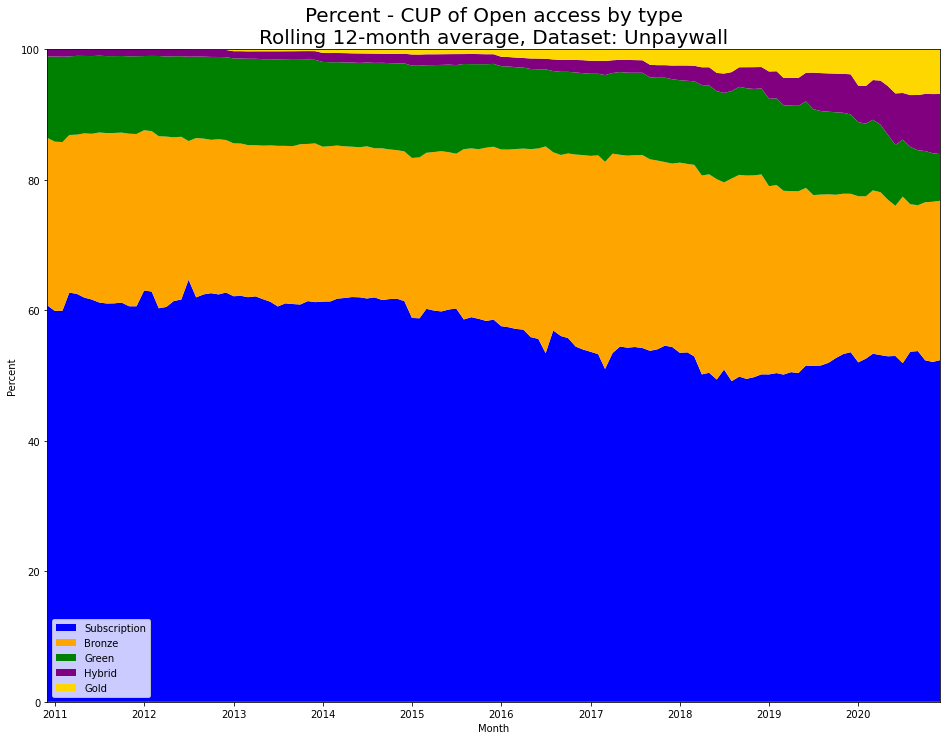

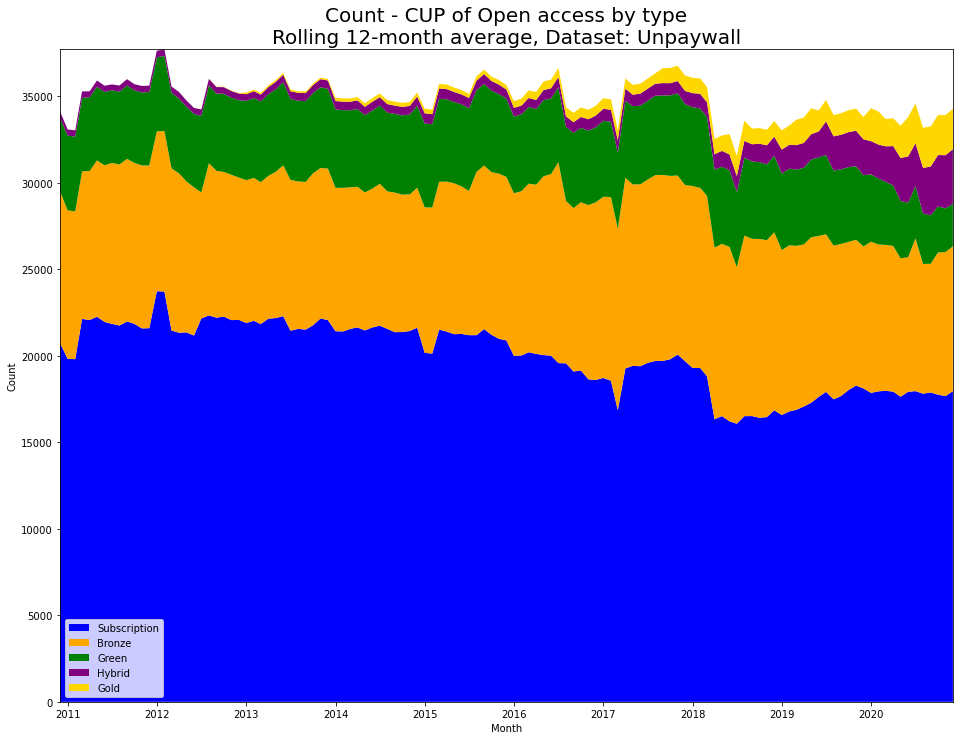

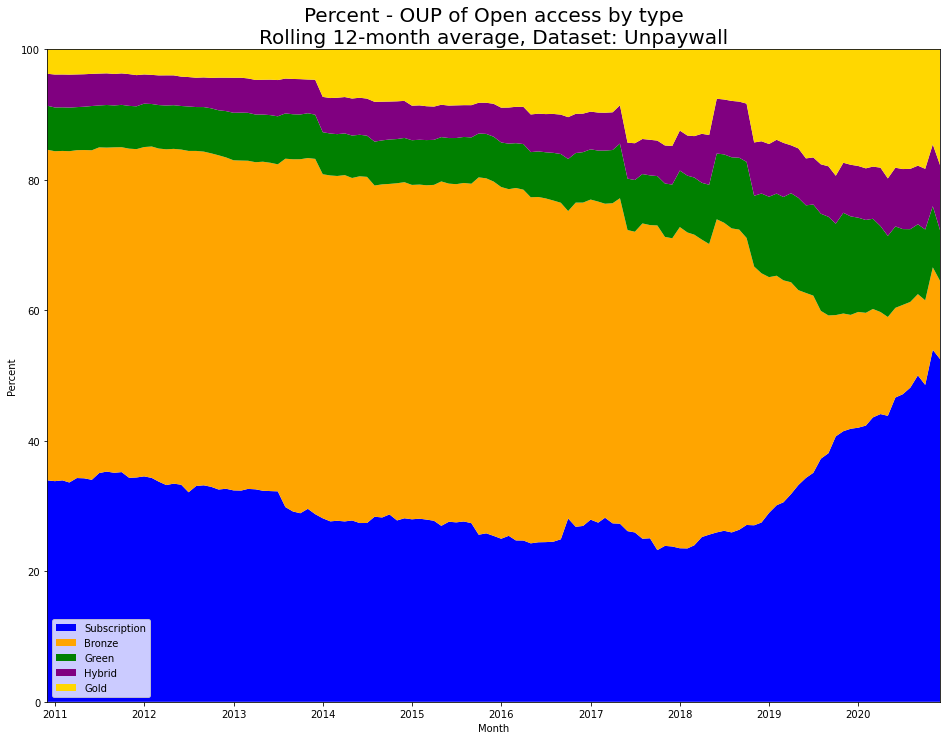

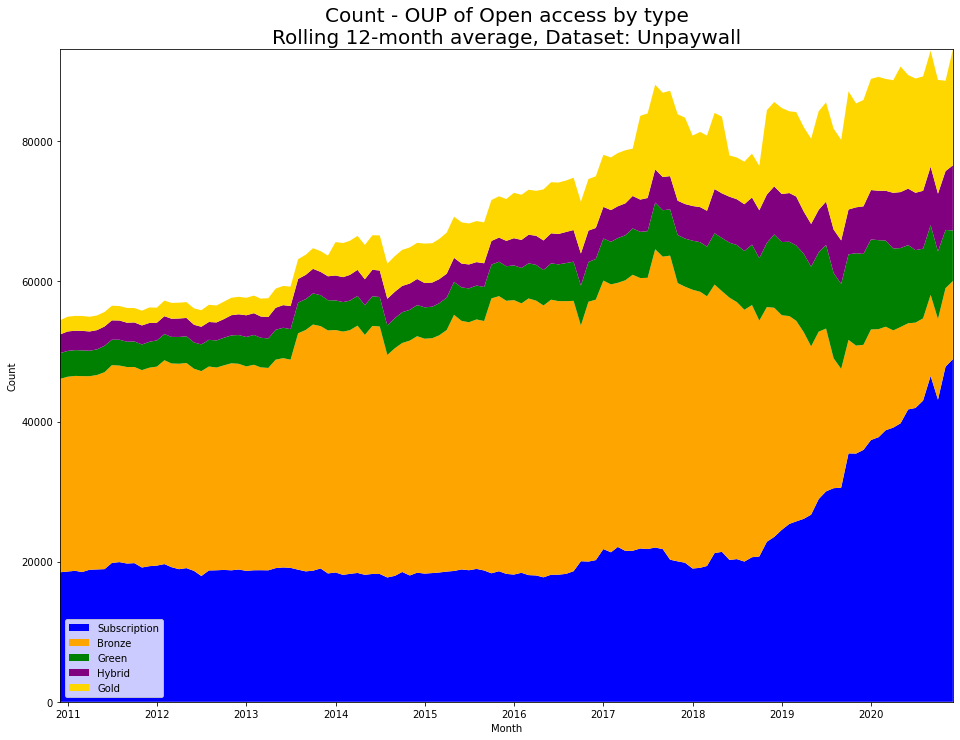

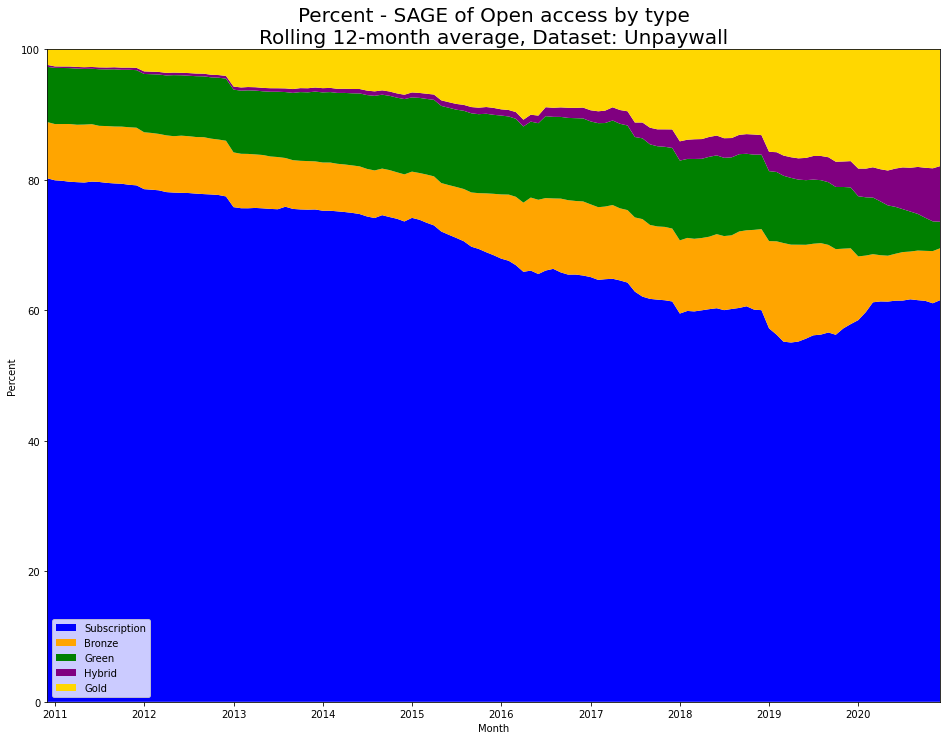

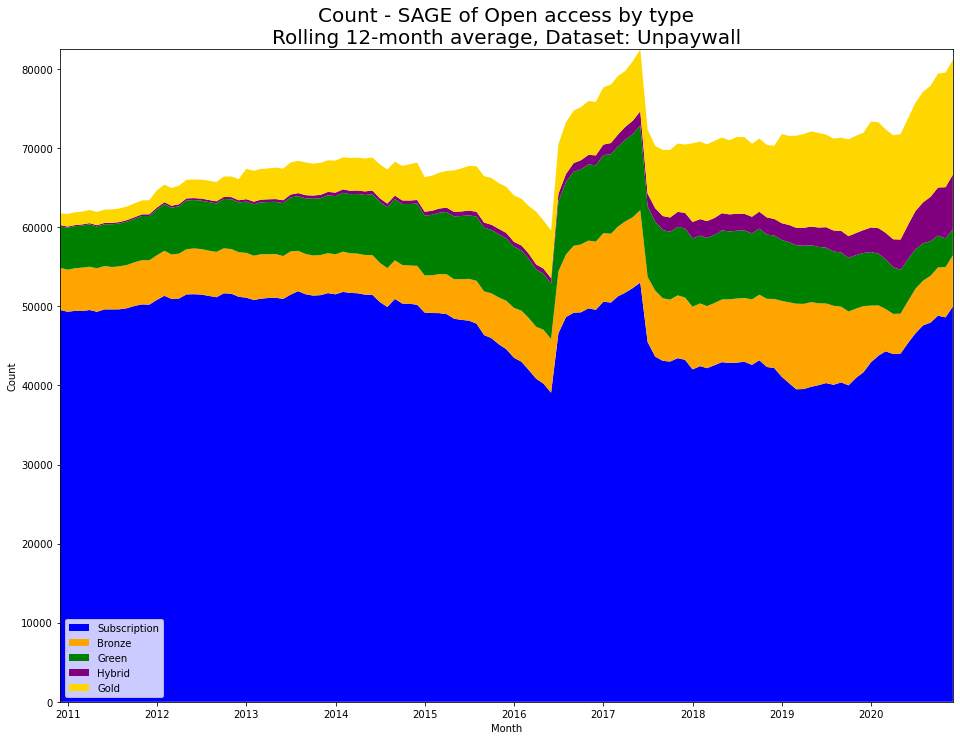

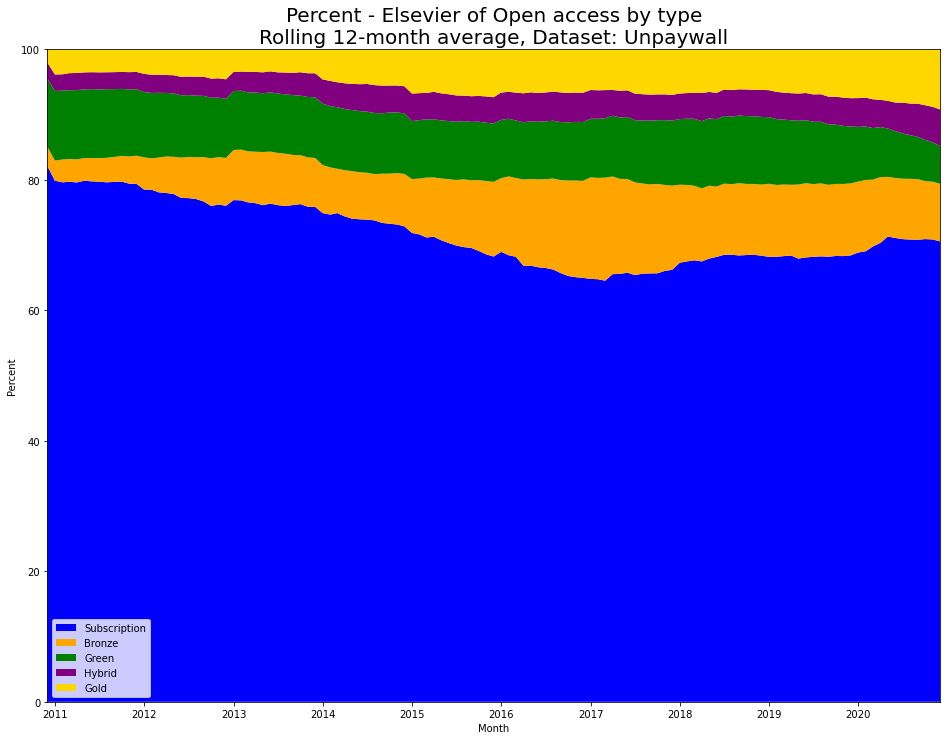

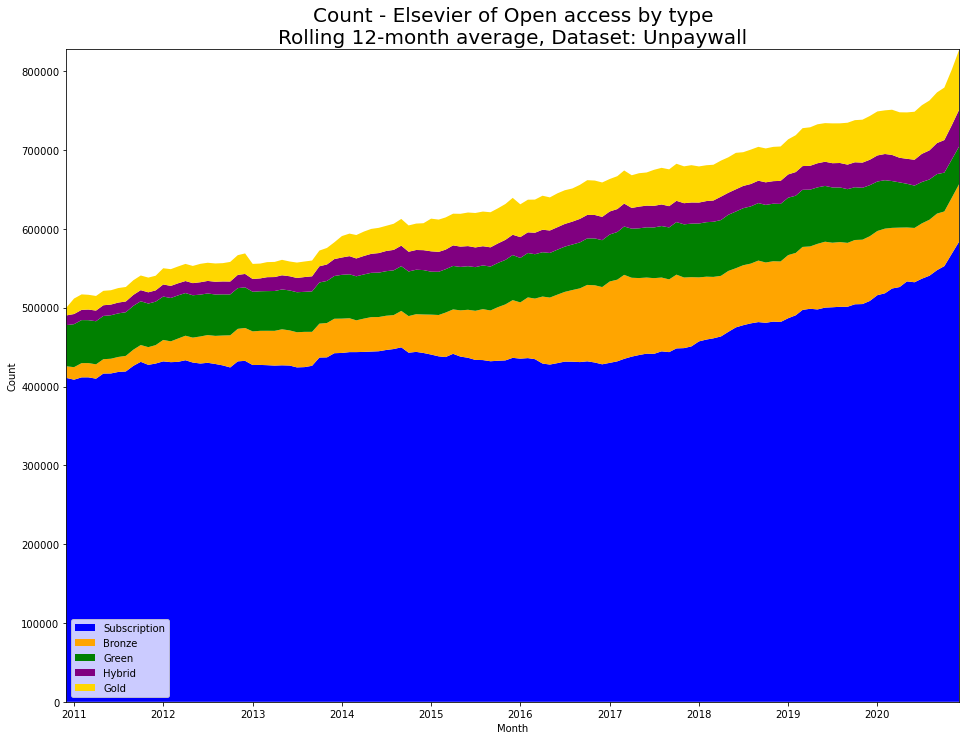

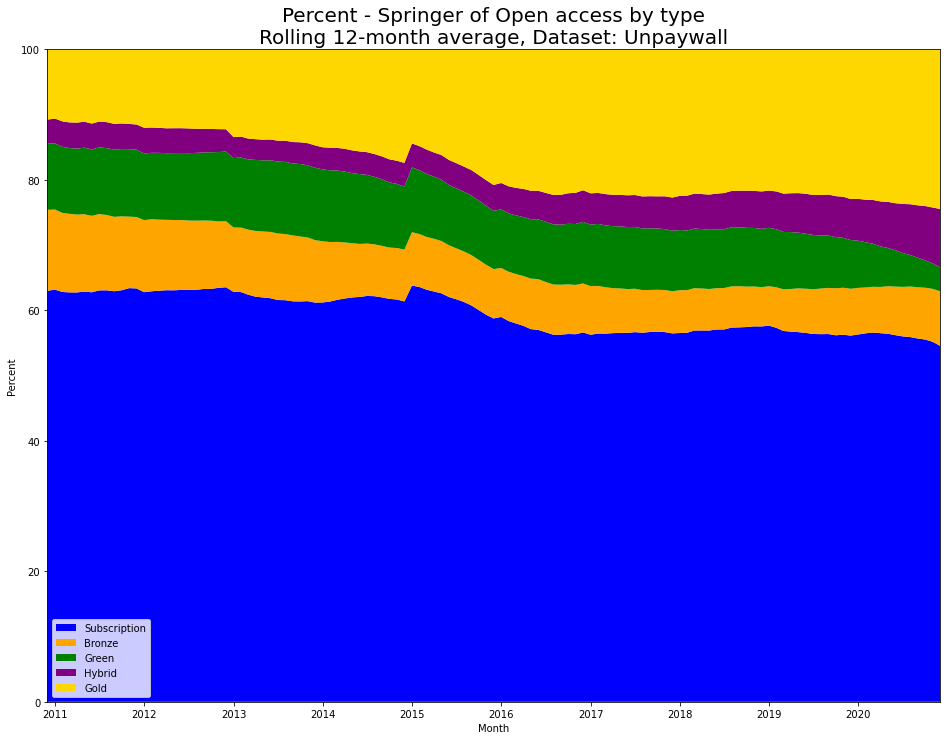

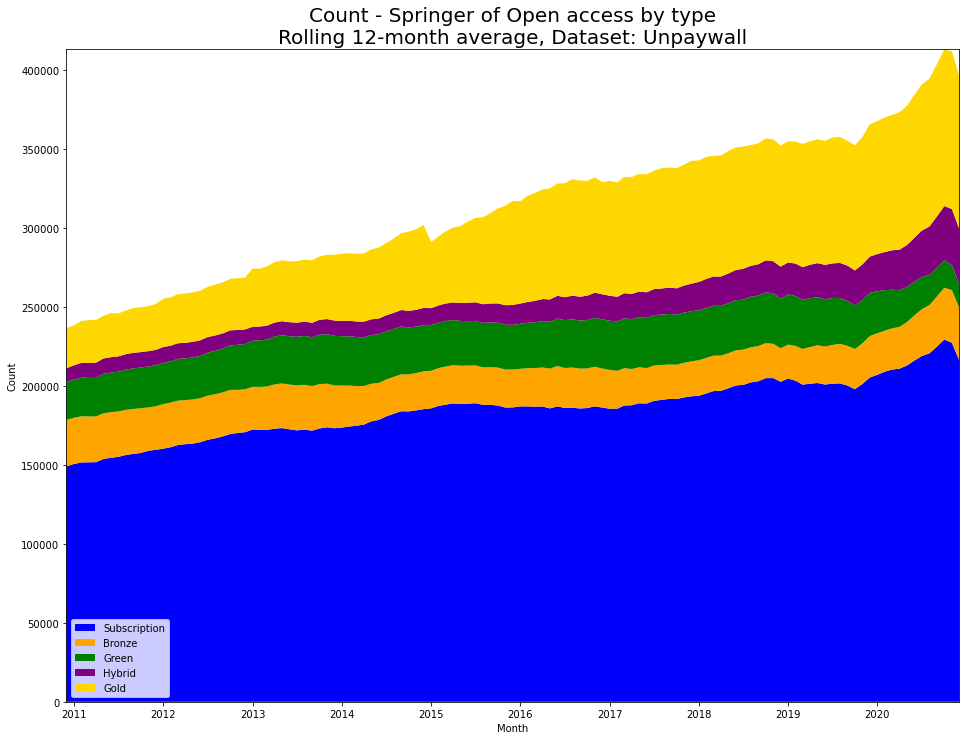

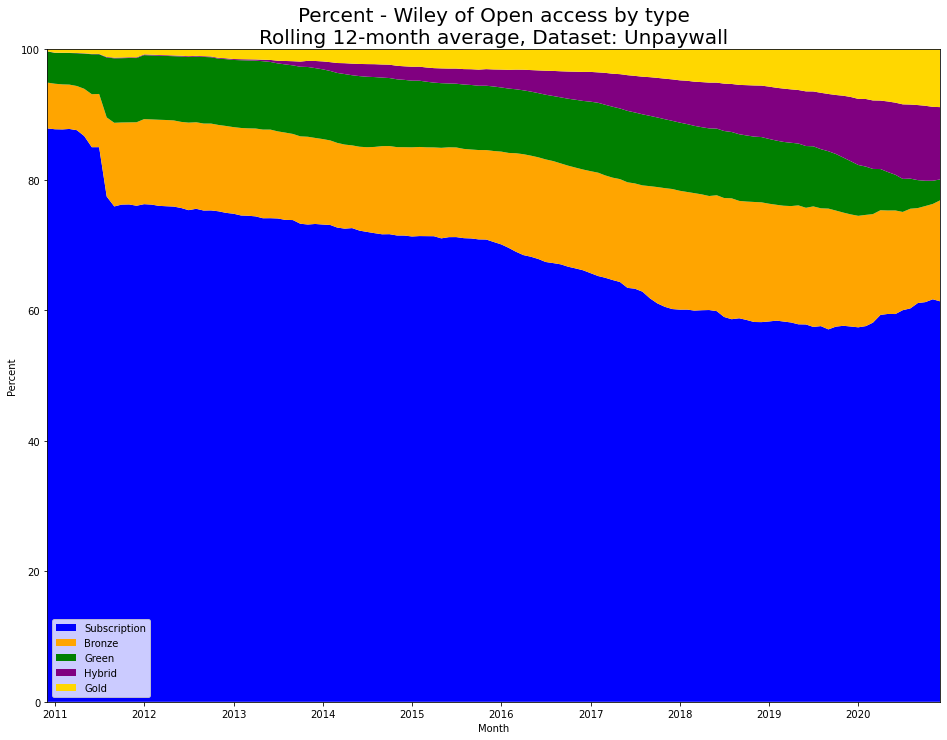

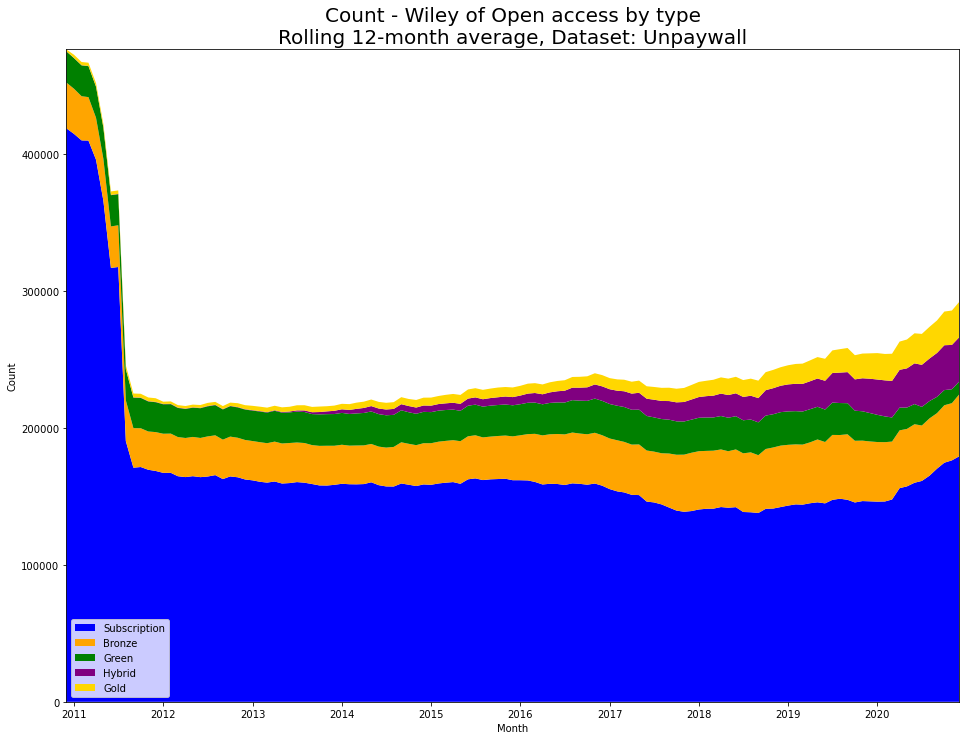

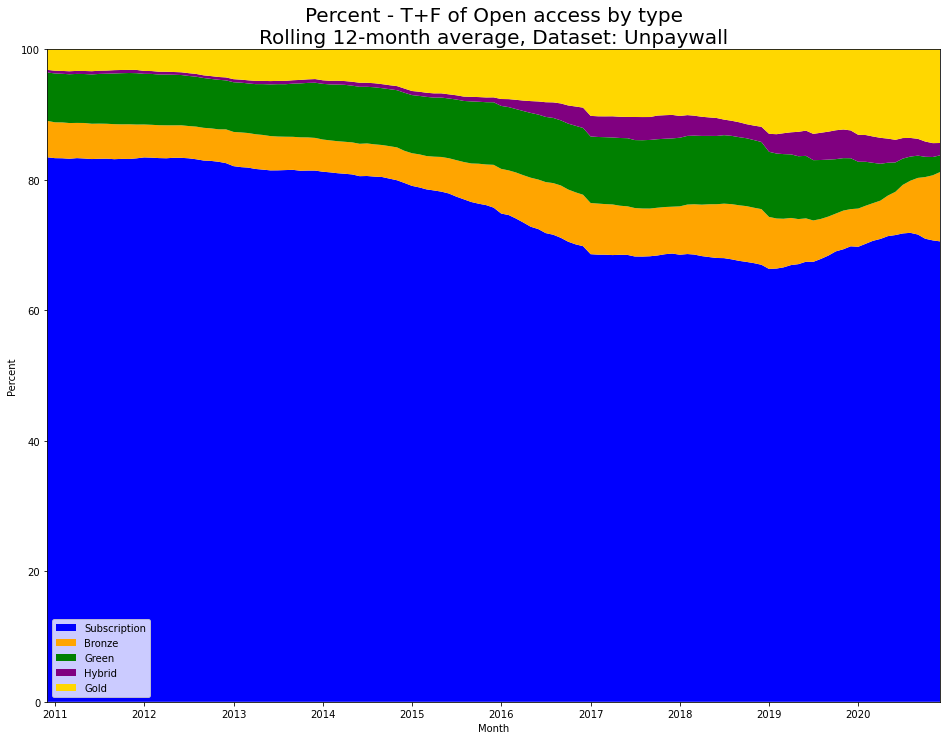

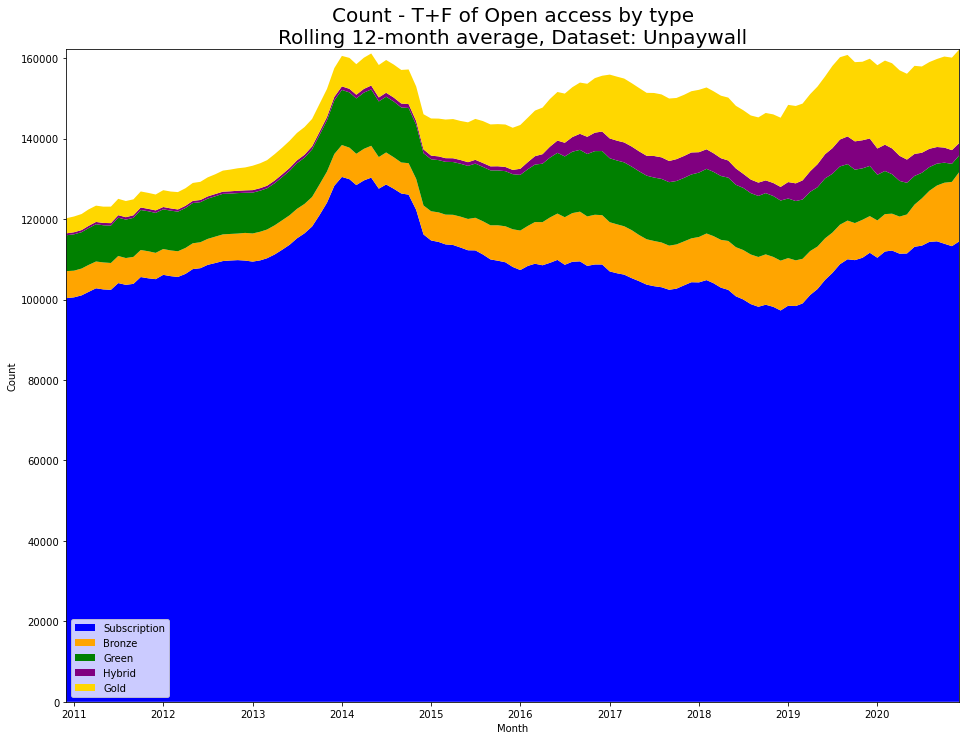

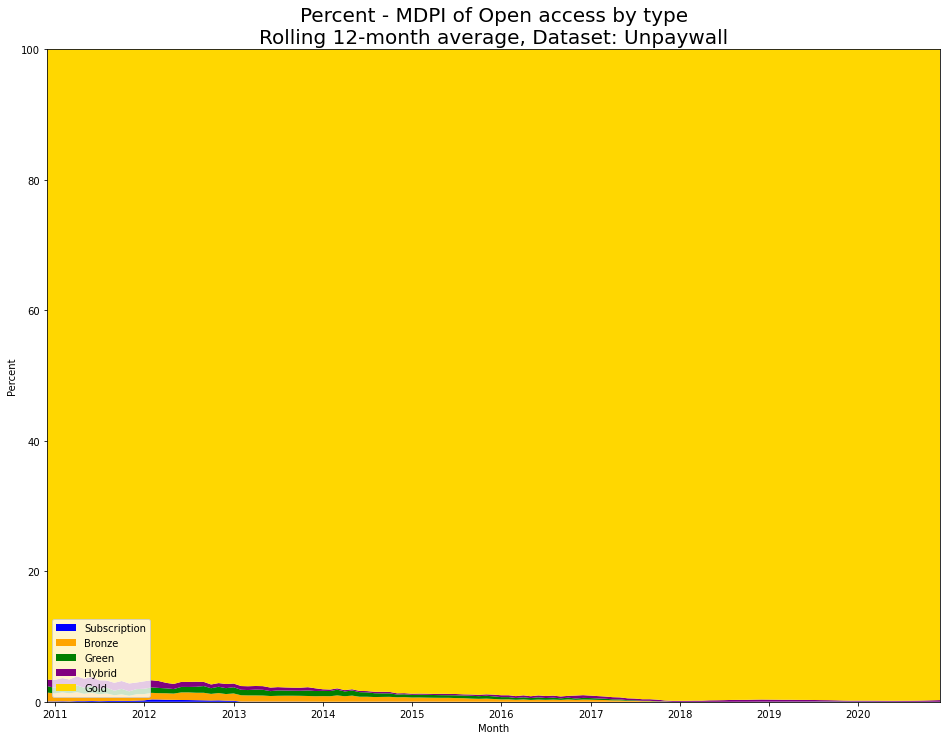

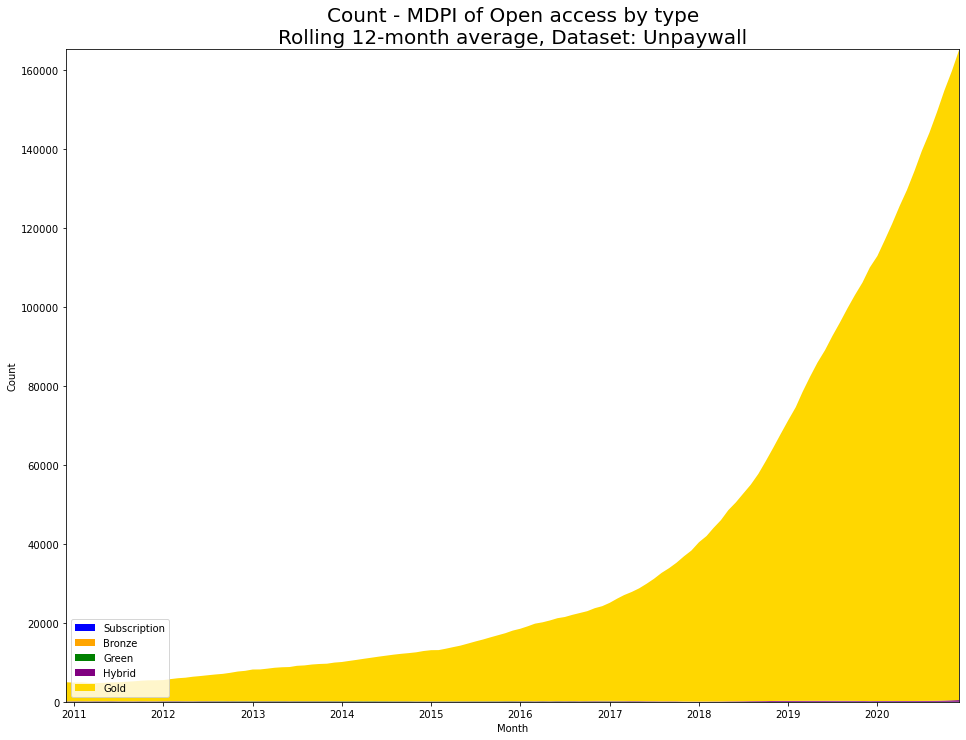

Done


In [12]:
for publisher in publisher_dct:
    # drop MDPI since they should be 100% Gold
    if publisher != 'MDPI':
        publisher_plot(df,publisher,percent=True)
        publisher_plot(df,publisher,percent=False)
print('Done')
    
